### Importing libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
import albumentations as A
# from torchvision import datasets, transforms
import importlib
from torch_lr_finder import LRFinder
from utils import utils
from utils.utils import fabric
from utils.dataset import Dataset
from utils.scheduler import Scheduler
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image, scale_cam_image
import warnings

warnings.filterwarnings('ignore')

Using bfloat16 Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


In [2]:
# Initialize
utils.set_seed(1)

### Import dataset: CIFAR10

In [3]:
dataset = Dataset('CIFAR10', batch_size=512, trans_lib='albumentations')

# Add augmentations for training dataset
dataset.dt.set_transforms('train', [
    A.PadIfNeeded(min_height=40, min_width=40), #, always_apply=True
    A.RandomCrop(height=32, width=32), # , always_apply=True
    A.HorizontalFlip(),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=dataset.dt.mean)
], True)

Files already downloaded and verified
Files already downloaded and verified
The mean and SD for CIFAR10 dataset are [0.49139968 0.48215841 0.44653091] and [0.24703223 0.24348513 0.26158784] respectively.
Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader, test_loader = dataset.get_data_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
torch.mean(images), torch.std(images), torch.min(images), torch.max(images)

(tensor(0.0366), tensor(0.9997), tensor(-1.9892), tensor(2.1268))

### Visualize input images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


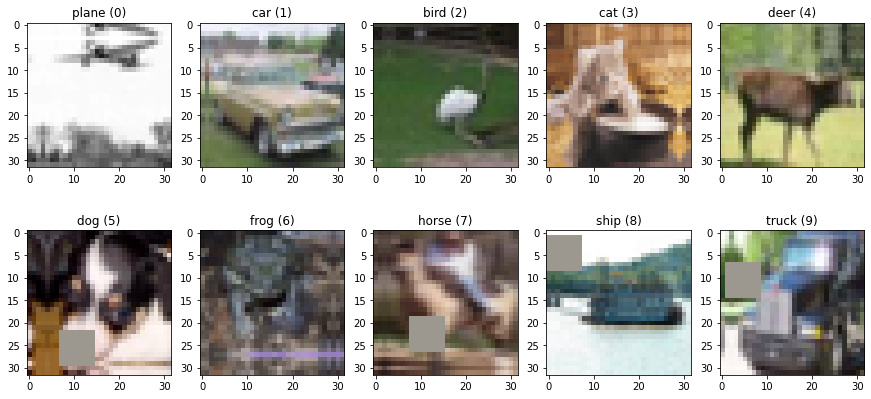

In [7]:
label_mapper = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
utils.visualize_images(images, labels, dataset.dt.mean, dataset.dt.std, label_mapper, n_cols=5, figsize=(15, 7))

### Model Training

In [8]:
from models import resnet
importlib.reload(resnet)

<module 'models.resnet' from 'd:\\Self Learning\\TSAI\\TSAI\\S11\\models\\resnet.py'>

In [9]:
from models.resnet import ResNet18
device = utils.get_device()
in_ch = 3
model = ResNet18().to(device)
summary(model, input_size=(in_ch, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Files already downloaded and verified
0 torch.Size([1, 512, 1, 1])
1 torch.Size([1, 512])
2 torch.Size([1, 10])
0 torch.Size([1, 512, 1, 1])
1 torch.Size([1, 512])
2 torch.Size([1, 10])


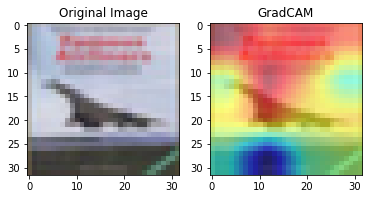

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Load the CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(dataset.dt.mean, dataset.dt.std)])

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# Load the ResNet50 model
# model = resnet50(pretrained=True)

# Define the target layer for GradCAM
target_layers = [model.layer4[-1]]

# Define the input tensor
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[3]
input_tensor = img.unsqueeze(0)

# Create a GradCAM object
gradcam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

# Generate the CAM
out = model(input_tensor.to(device))
label = out.argmax(dim=1)
targets = [ClassifierOutputTarget(label)]
grayscale_cam = gradcam(input_tensor=input_tensor, targets=targets) # , eigen_smooth=True
# grayscale_cam = gradcam(input_tensor=input_tensor)
# grayscale_cam = grayscale_cam[0, :]

# Overlay the CAM on the original image
image = utils.denormalise(img, dataset.dt.mean, dataset.dt.std)
image = image.permute(1, 2, 0).numpy()
cam_image = show_cam_on_image(image, np.moveaxis(grayscale_cam, [0], [2]), use_rgb=True)
# cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)

# Display the original image and the CAM
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[1].imshow(cam_image)
ax[1].set_title('GradCAM')
plt.show()

### LR Finder

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.52E-02


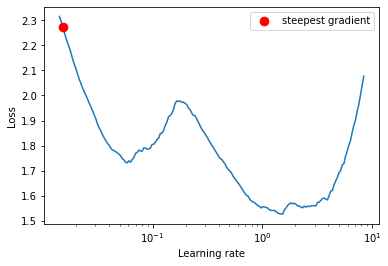

Max LR suggsted by LRFinder is 0.015167168884709228


In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
_, max_lr = lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

print(f'Max LR suggsted by LRFinder is {max_lr}')

In [12]:
num_epochs = 20
steps_per_epoch = len(train_loader)

scheduler = Scheduler('OneCycleLR', {
    'optimizer': optimizer,
    'max_lr': max_lr,
    'steps_per_epoch': steps_per_epoch, 
    'epochs': num_epochs, 
    'pct_start': 5/num_epochs,
    'div_factor': 100,
    'final_div_factor': 100,
    'three_phase': False,
    'anneal_strategy': 'linear',
    'verbose': False
})

for epoch in range(1, num_epochs+1):
    print('EPOCH:', epoch)
    model.model_train(device, train_loader, criterion, optimizer, scheduler)
    model.model_test(device, test_loader, criterion)

EPOCH: 1


Train: Loss=1.3072720766067505 Batch_id=97 Accuracy=39.53: 100%|██████████| 98/98 [01:30<00:00,  1.09it/s]


Test: Average loss: 0.0025, Accuracy: 5542/10000 (55.42%), Accuracy Diff: 15.886



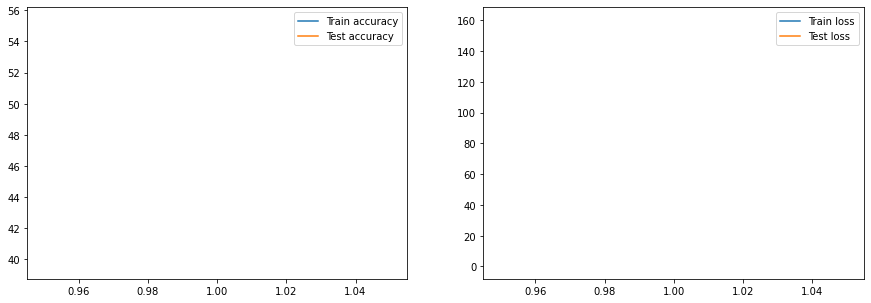

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
model.plot_accuracy()
plt.subplot(122)
model.plot_loss()
plt.savefig('images/model.png')
plt.show()

In [14]:
max(model.train_accuracy), max(model.test_accuracy)

(39.534, 55.42)

### Visualizing incorrect predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


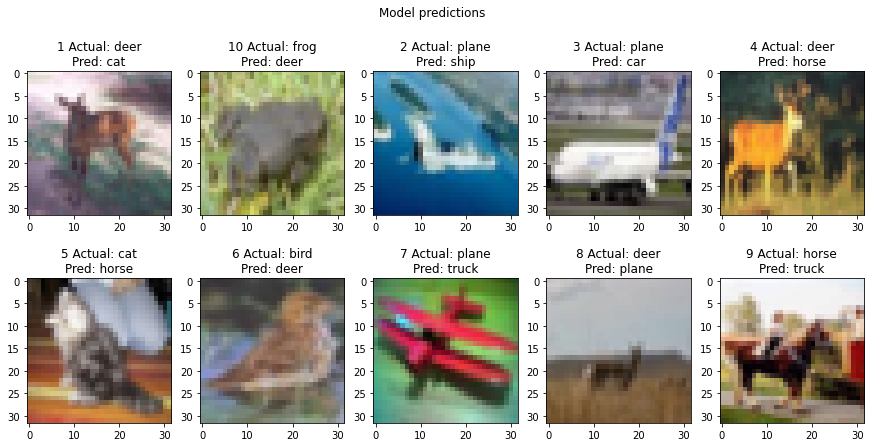

In [15]:
label_mapper = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images, actual, pred = model.get_incorrect_pred(device, test_loader)
images, actual, pred = images.to('cpu'), actual.to('cpu'), pred.to('cpu')
labels = [str(indx + 1) + ' Actual: %s' % label_mapper[act.item()] + '\n' + \
    'Pred: %s' % label_mapper[pr.item()] for indx, (act, pr) in enumerate(zip(actual, pred))]
utils.visualize_images(images, labels, dataset.dt.mean, dataset.dt.std, n_cols=5, figsize=(15, 7), img_title='Model predictions')
plt.savefig('images/incorrect_pred.png')

### Visualizing incorrect predictions using GradCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


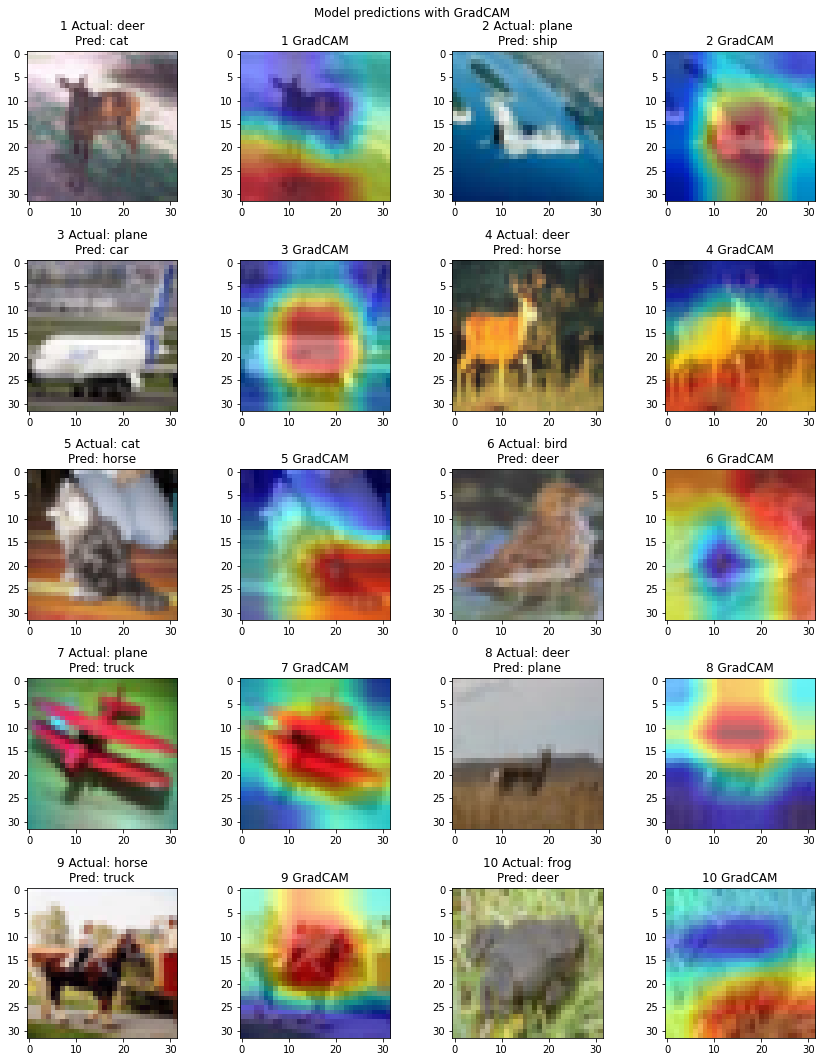

In [27]:
utils.visualize_imgs_with_gradcam(model, images, labels, pred, dataset.dt.mean, dataset.dt.std, 
    n_cols=4, figsize=(12, 15), img_title='Model predictions with GradCAM')

plt.tight_layout()
plt.show()